In [41]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
import tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [42]:
def load_single_voxel_grid(path, out_vox_res=256):
        with np.load(path) as da:
            voxel_grid = da['arr_0']
        if len(voxel_grid)<=0:
            print (" load_single_voxel_grid error: ", path)
            exit()

        #Data.plotFromVoxels(voxel_grid)
        voxel_grid = voxel_grid_padding(voxel_grid)

        ## downsample
        if out_vox_res < 256:
            voxel_grid = Data.vox_down_single(voxel_grid, to_res=out_vox_res)
        return voxel_grid
    
def voxel_grid_padding(a):
    x_d = a.shape[0]
    y_d = a.shape[1]
    z_d = a.shape[2]
    channel = a.shape[3]
    ori_vox_res = 256
    size = [ori_vox_res, ori_vox_res, ori_vox_res,channel]
    b = np.zeros(size,dtype=np.float32)

    bx_s = 0;bx_e = size[0];by_s = 0;by_e = size[1];bz_s = 0; bz_e = size[2]
    ax_s = 0;ax_e = x_d;ay_s = 0;ay_e = y_d;az_s = 0;az_e = z_d
    if x_d > size[0]:
        ax_s = int((x_d - size[0]) / 2)
        ax_e = int((x_d - size[0]) / 2) + size[0]
    else:
        bx_s = int((size[0] - x_d) / 2)
        bx_e = int((size[0] - x_d) / 2) + x_d

    if y_d > size[1]:
        ay_s = int((y_d - size[1]) / 2)
        ay_e = int((y_d - size[1]) / 2) + size[1]
    else:
        by_s = int((size[1] - y_d) / 2)
        by_e = int((size[1] - y_d) / 2) + y_d

    if z_d > size[2]:
        az_s = int((z_d - size[2]) / 2)
        az_e = int((z_d - size[2]) / 2) + size[2]
    else:
        bz_s = int((size[2] - z_d) / 2)
        bz_e = int((size[2] - z_d) / 2) + z_d
    b[bx_s:bx_e, by_s:by_e, bz_s:bz_e,:] = a[ax_s:ax_e, ay_s:ay_e, az_s:az_e, :]

    #Data.plotFromVoxels(b)
    return b

In [43]:
def voxel2mesh(voxels, surface_view):
    cube_verts = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0],
                  [1, 1, 1]]  # 8 points

    cube_faces = [[0, 1, 2], [1, 3, 2], [2, 3, 6], [3, 7, 6], [0, 2, 6], [0, 6, 4], [0, 5, 1],
                  [0, 4, 5], [6, 7, 5], [6, 5, 4], [1, 7, 3], [1, 5, 7]]  # 12 face

    cube_verts = np.array(cube_verts)
    cube_faces = np.array(cube_faces) + 1

    scale = 0.01
    cube_dist_scale = 1.1
    verts = []
    faces = []
    curr_vert = 0

    positions = np.where(voxels > 0.3)
    voxels[positions] = 1
    for i, j, k in zip(*positions):
        # identifies if current voxel has an exposed face
        if not surface_view or np.sum(voxels[i-1:i+2, j-1:j+2, k-1:k+2]) < 27:
            verts.extend(scale * (cube_verts + cube_dist_scale * np.array([[i, j, k]])))
            faces.extend(cube_faces + curr_vert)
            curr_vert += len(cube_verts)

    return np.array(verts), np.array(faces)


def write_obj(filename, verts, faces):
    """ write the verts and faces on file."""
    with open(filename, 'w') as f:
        # write vertices
        f.write('g\n# %d vertex\n' % len(verts))
        for vert in verts:
            f.write('v %f %f %f\n' % tuple(vert))

        # write faces
        f.write('# %d faces\n' % len(faces))
        for face in faces:
            f.write('f %d %d %d\n' % tuple(face))


def voxel2obj(filename, pred, surface_view = True):
    verts, faces = voxel2mesh(pred, surface_view)
    write_obj(filename, verts, faces)
    return  verts, faces


In [7]:
bench = load_single_voxel_grid('./3D-RecGAN/02_1224.npz')

In [44]:
    def plotFromVoxels(voxels,title=''):
        if len(voxels.shape)>3:
            x_d = voxels.shape[0]
            y_d = voxels.shape[1]
            z_d = voxels.shape[2]
            v = voxels[:,:,:,0]
            v = np.reshape(v,(x_d,y_d,z_d))
        else:
            v = voxels
        x, y, z = v.nonzero()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, zdir='z', c='red')
        #plt.show()
        plt.title(title)
        from matplotlib.pyplot import show
        show(block=False)


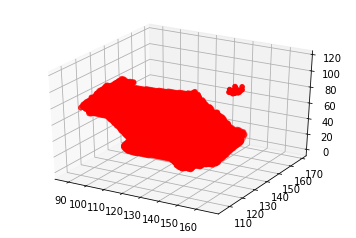

In [9]:
plotFromVoxels(couch)

In [45]:
result_path = ('/home/josh/git_folder/3D_insight/3D-RecGAN/demo_result.mat')
output = scipy.io.loadmat(result_path)


In [48]:
x_sample = output['X_test']
y_pred = output['Y_test_pred']
y_true = output['Y_test_true']

In [49]:
y_true = y_true.reshape(256,256,256)

In [51]:
output = voxel2obj('voxpred_bench2.obj', y_pred)